In [1]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import cv2
from PIL import Image
from torchvision import transforms
import torch.optim as optim
from torch import nn
import torch.nn.functional as F
import torchvision
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [3]:
image_transforms = {
    'train':
    transforms.Compose([
        #transforms.Resize((227,227)),
        #transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        #transforms.RandomRotation(degrees=10),
        #transforms.RandomHorizontalFlip(),
        #transforms.CenterCrop(size=227),
        transforms.Resize((256,256)),
        transforms.RandomRotation(degrees=10),
        transforms.RandomHorizontalFlip(),
        transforms.RandomResizedCrop(size=227, scale=(0.8, 1.0)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])  
    ]),
    'test':
    transforms.Compose([
        transforms.Resize((227,227)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [4]:
class GTSRBDataset(Dataset):

    def __init__(self, csv_file, root_dir, transform=None):
        self.GTSRB_frame = pd.read_csv(os.path.join(root_dir,csv_file))
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.GTSRB_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        img_path = os.path.join(self.root_dir, self.GTSRB_frame.iloc[idx, -1])
        img = cv2.imread(img_path)
        img = Image.fromarray(img)
        img = img.convert('RGB')
        if self.transform:
            img = self.transform(img)            
        label = self.GTSRB_frame.iloc[idx, -2]
        return img, label

In [5]:
path = '../gtsrb-german-traffic-sign'
train_dataset = GTSRBDataset('Train.csv', path, image_transforms['train'])
test_dataset = GTSRBDataset('Test.csv', path, image_transforms['test'])

In [6]:
len(train_dataset)/32

1225.28125

In [7]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)
classes = tuple(range(43))

In [8]:
class AlexNet(torch.nn.Module):
    
    def __init__(self):
        super(AlexNet, self).__init__()
        self.conv1 = nn.Conv2d(3,96,kernel_size = 11,stride=4)
        self.pool1 = nn.MaxPool2d(3,2)
        self.conv2 = nn.Conv2d(96,256,kernel_size = 5,stride=1,padding=2)
        self.pool2 = nn.MaxPool2d(3,2)
        self.conv3 = nn.Conv2d(256,384,kernel_size = 3,stride=1,padding=1)
        self.conv4 = nn.Conv2d(384,384,kernel_size = 3,stride=1,padding=1)
        self.conv5 = nn.Conv2d(384,256,kernel_size = 3,stride=1,padding=1)
        self.pool3 = nn.MaxPool2d(3,2)
        self.fc1 = nn.Linear(6 * 6 * 256, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, 43)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        out = self.relu(self.conv1(x))
        out = self.relu(self.pool1(out))
        out = self.relu(self.conv2(out))
        out = self.relu(self.pool2(out))
        out = self.relu(self.conv3(out))
        out = self.relu(self.conv4(out))
        out = self.relu(self.conv5(out))
        out = self.relu(self.pool3(out))
        out = out.view(-1, 6 * 6 * 256)
        print(out.shape)
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc3(out)
        out = F.softmax(out, dim = 1)
        return out

In [9]:
net = AlexNet()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(),lr = 0.00001)

In [10]:
Loss = []
for epoch in range(100):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        
        net.to(device)
        
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 600 == 599:    # print every 600 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 600))
            Loss.append(running_loss / 600)
            running_loss = 0.0
        
print('Finished Training')

torch.Size([32, 9216])
torch.Size([32, 9216])
torch.Size([32, 9216])
torch.Size([32, 9216])
torch.Size([32, 9216])


KeyboardInterrupt: 

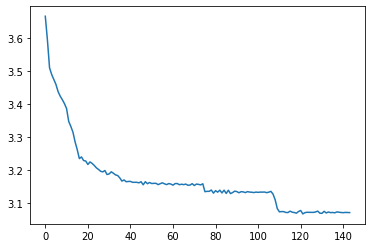

In [73]:
plt.plot(Loss)

In [74]:
PATH = "AlexNet lr 0.00001"
torch.save(net.state_dict(), PATH)

In [9]:
def imshow(img):
    img = img / 2 + 0/5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


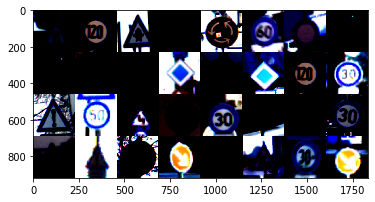

GroundTruth:     24     8    11    31    40     3    15    38    38     4     8    12    38    12     8     1    18     2    21     8     1    38    25     1    31    18     2    38     4    25     1    38


In [10]:
dataiter = iter(test_loader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(32)))

In [11]:
net = AlexNet()
net.load_state_dict(torch.load("../GTSRB parameters/AlexNet lr 0.00001"))

<All keys matched successfully>

In [12]:
outputs = net(images)

In [13]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(32)))

Predicted:     25     5    11    31    38     3    15    38    38     4     4    12    38    12     5     1    18     2    21     5     1    38    38     1    31    11     1    38     4    25     1    38


In [14]:
correct = 0
total = 0
net.to(device)
with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the test images: 72 %


In [15]:
class_correct = list(0. for i in range(43))
class_total = list(0. for i in range(43))
with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(len(labels)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(43):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of     0 :  0 %
Accuracy of     1 : 97 %
Accuracy of     2 : 98 %
Accuracy of     3 : 94 %
Accuracy of     4 : 97 %
Accuracy of     5 : 95 %
Accuracy of     6 : 86 %
Accuracy of     7 :  0 %
Accuracy of     8 :  0 %
Accuracy of     9 : 99 %
Accuracy of    10 : 97 %
Accuracy of    11 : 100 %
Accuracy of    12 : 95 %
Accuracy of    13 : 99 %
Accuracy of    14 : 100 %
Accuracy of    15 : 99 %
Accuracy of    16 :  0 %
Accuracy of    17 : 92 %
Accuracy of    18 : 90 %
Accuracy of    19 :  0 %
Accuracy of    20 : 100 %
Accuracy of    21 : 98 %
Accuracy of    22 :  0 %
Accuracy of    23 :  0 %
Accuracy of    24 :  0 %
Accuracy of    25 : 97 %
Accuracy of    26 :  0 %
Accuracy of    27 :  0 %
Accuracy of    28 :  0 %
Accuracy of    29 :  0 %
Accuracy of    30 : 79 %
Accuracy of    31 : 98 %
Accuracy of    32 : 100 %
Accuracy of    33 :  0 %
Accuracy of    34 :  0 %
Accuracy of    35 :  0 %
Accuracy of    36 :  0 %
Accuracy of    37 :  0 %
Accuracy of    38 : 98 %
Accuracy of    39 :  